## Implementation details of Deep Weighted Monte Carlo

In this notebook we publish the code used for producing the results presented in the paper "Deep Weighted Monte Carlo: A hybrid option pricing framework using neural networks". The GBP swaption data collected from ICAP is however confidential and therefore we can only provide information about the input shape.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.stats import norm
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
import matplotlib
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-10-16 17:55:17.961029: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.keras.backend.set_floatx('float64')

## Some useful functions and classes

In [3]:
def impVol_(F, K, t, T, C, pricing_func, x0=0.005):
    """
    Iterative function to compute the implied volatility.
    """
    res = root_scalar( f=pricing_func, args=(F, K, t, T, C), method='bisect', bracket=[0.00001,100], xtol=0.0000001, x0=x0 )
    return res.root

def bachelierCall_( sigma, F, K, t, T ):
    """
    Calculates the price of a call option using the Bachelier formula.
    """
    z = (F - K) / (sigma*np.sqrt(T-t))
    C = (F-K)*norm.cdf(z) + sigma*np.sqrt( T-t )*norm.pdf(z)
    return C

def bachelierPut_( sigma, F, K, t, T ):
    """
    Calculates the price of a put option using the Bachelier formula.
    """
    z = (F - K) / (sigma*np.sqrt(T-t))
    C = (K-F)*norm.cdf(-z) + sigma*np.sqrt( T-t )*norm.pdf(z)
    return C

class MinMaxScaler():
    """
    A class for scaling the volatility surfaces into the [0, 1] range.
    """
    
    def __init__(self):
        self.min = None
        self.max = None
    
    def fit(self, data):
        self.min = np.min( data )
        self.max = np.max( data )
        
    def transform(self, data):
        return ( data - self.min ) / (self.max - self.min)

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
        
    def inverse_transform(self, data):
        return data * (self.max - self.min) + self.min
    
class save_best_weights(tf.keras.callbacks.Callback):
    """
    A class for saving the actual weights of the model when it shows the best performance on the validation set.
    """
    
    def __init__(self):
        super(save_best_weights, self).__init__()
        self.best_weights = None    
        self.best = np.Inf
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if np.less(current_loss, self.best):
            self.best = current_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
            print('\nSaving weights validation loss= {0:6.4f} \n'.format(current_loss))

## Creating the Variational Autoencoder

In [4]:
class Sampling(layers.Layer):
    """This layer samples z from a Gaussian distribution defined by z_mean and z_log_var"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Creating the encoder

In [5]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(49,))
x = layers.Dense(10, activation="elu")(encoder_inputs)
x = layers.Dense(10, activation="elu")(x)
z_mean = layers.Dense(latent_dim, activation="linear", name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, activation="linear", name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 49)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 10)           500         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 10)           110         ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 3)            33          ['dense_1[0][0]']                
                                                                                            

2022-10-16 17:55:24.970239: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-16 17:55:24.970265: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kunsagi-ThinkPad-E15-Gen-2
2022-10-16 17:55:24.970268: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kunsagi-ThinkPad-E15-Gen-2
2022-10-16 17:55:24.970367: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-10-16 17:55:24.970381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-10-16 17:55:24.970384: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-10-16 17:55:24.970738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to us

### Creating the decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim+2,))
x = layers.Dense(10, activation="elu")(latent_inputs)
x = layers.Dense(10, activation="elu")(x)
decoder_outputs = layers.Dense(1, activation="elu", name="dec_out")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_2 (Dense)             (None, 10)                60        
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dec_out (Dense)             (None, 1)                 11        
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


### Putting them together

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, strikeOffsets, expiries, beta, z_mean_ref, z_log_var_ref, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.z_mean_ref = tf.constant(z_mean_ref, dtype=tf.float64)
        self.z_log_var_ref = tf.constant(z_log_var_ref, dtype=tf.float64)
        self.strikeOffsets = tf.constant(strikeOffsets)
        self.expiries = tf.constant(expiries)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
        ]
    
    def call(self, inp):
        z_mean, z_log_var, z = self.encoder(inp)
        IV_rec = self.decode( z_mean )
        return IV_rec
    
    def decode(self, inputs):
        vols_list = []
        shp = tf.shape(inputs)
        i = 0
        dec_inp = tf.concat( 
            [
                tf.cast(tf.fill([shp[0],1], self.strikeOffsets[i]), dtype=tf.float64),
                tf.cast(tf.fill([shp[0],1], self.expiries[i]), dtype=tf.float64),
                inputs
            ]
            , axis=1 
        )
        v = self.decoder(dec_inp)
        for i in range(1,49):
            dec_inp = tf.concat( 
                [
                    tf.cast(tf.fill([shp[0],1], self.strikeOffsets[i]), dtype=tf.float64),
                    tf.cast(tf.fill([shp[0],1], self.expiries[i]), dtype=tf.float64),
                    inputs
                ]
                , axis=1 
            )
            v_ = self.decoder(dec_inp)
            v = tf.concat( [v, v_], axis=1 )
        return v
    
    def train_step(self, data_):
        IV_real, _ = data_
        IV_real = tf.convert_to_tensor(IV_real, dtype=tf.float64)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(IV_real)
            IV_rec = self.decode(z)

            IV_rec_loss = self.compiled_loss(IV_real, IV_rec)
            kl_loss = -0.5 * (z_log_var - self.z_log_var_ref + 1 - tf.square(z_mean - self.z_mean_ref) - tf.exp(z_log_var)/tf.exp(self.z_log_var_ref) )
            kl_loss = tf.reduce_mean(tf.reduce_mean(kl_loss, axis=1))
            total_loss = IV_rec_loss + self.beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "IV_rec_loss": IV_rec_loss,
            "kl_loss": kl_loss
        }
    
    def test_step(self, data_):
        IV_real, _ = data_
        IV_real = tf.convert_to_tensor(IV_real, dtype=tf.float64)
        z_mean, z_log_var, z = self.encoder(IV_real)
        IV_rec = self.decode(z_mean)

        IV_rec_loss = self.compiled_loss(IV_real, IV_rec)
        kl_loss = -0.5 * (z_log_var - self.z_log_var_ref + 1 - tf.square(z_mean - self.z_mean_ref) - tf.exp(z_log_var)/tf.exp(self.z_log_var_ref) )
        kl_loss = tf.reduce_mean(tf.reduce_mean(kl_loss, axis=1))
        total_loss = IV_rec_loss + self.beta*kl_loss
        return {
            "loss": total_loss,
            "IV_rec_loss": IV_rec_loss,
            "kl_loss": kl_loss
        }


## Reading the data

# Here we create dummy historical data containing the same volatility surface for every business day !

In [10]:
outdir = "data/"

In [11]:
dates = pd.read_csv( outdir + "dates.csv" )


volsurfaces = np.array( [[[0.006514, 0.006775, 0.006899, 0.007019, 0.007136, 0.00725 ,
         0.007476],
        [0.007118, 0.007352, 0.007462, 0.007568, 0.00767 , 0.00777 ,
         0.007964],
        [0.007949, 0.008165, 0.008266, 0.008364, 0.008459, 0.008552,
         0.008733],
        [0.008451, 0.008639, 0.008727, 0.008813, 0.008896, 0.008978,
         0.009139],
        [0.00887 , 0.009005, 0.009069, 0.009131, 0.009192, 0.009253,
         0.009374],
        [0.008925, 0.009016, 0.00906 , 0.009103, 0.009146, 0.009189,
         0.009277],
        [0.008885, 0.00895 , 0.008981, 0.009012, 0.009043, 0.009075,
         0.009142]]] * 1338 )

In [12]:
volsurfaces.shape

(1338, 7, 7)

In [13]:
# Flattening the data
shp = volsurfaces.shape
volFlat_ = volsurfaces.reshape( (shp[0], shp[1]*shp[2]) )

In [14]:
# Scaling the volsurfaces into the [0,1] range
scaler = MinMaxScaler()
scaler.min = 0.002622
scaler.max = 0.009377
volFlat = scaler.transform(volFlat_)
#volFlat = scaler.fit_transform( volFlat_ )

In [15]:
# Defining the strike-maturity grid (deltaK: forward - strike)
deltaK = np.array([-50,-25,-12.5,0.0,12.5,25,50])/10000
strikeOffsets_ = deltaK.copy()
expiryMonths_ = np.array([9,12,18,24,36,48,60])
Ts_ = expiryMonths_/12.
strikeOffsetsMtx, expiryMonthsMtx = np.meshgrid( strikeOffsets_, expiryMonths_ )
strikeOffsets = strikeOffsetsMtx.flatten()
expiryMonths = expiryMonthsMtx.flatten()
Ts = expiryMonths / 12.
F0 = 0.0
Ks = F0 + strikeOffsets

## Splitting the data into training, test and validation sets

In [16]:
limit1 = int(0.7*volFlat.shape[0])

volFlat_train_ = volFlat[:limit1,:]
volFlat_test = volFlat[limit1:,:]

indices = np.arange(0, volFlat_train_.shape[0], 1, dtype=int)
np.random.shuffle(indices)

volFlat_val = volFlat_train_[indices[:100],:]
volFlat_train = volFlat_train_[indices[100:],:]


In [17]:
dates.iloc[limit1]

date    2019-04-05
Name: 936, dtype: object

In [18]:
print(volFlat_train.shape)
print(volFlat_test.shape)
print(volFlat_val.shape)

(836, 49)
(402, 49)
(100, 49)


### Loading the trained models

In [19]:
encoder = tf.keras.models.load_model( "vae_encoder" )
decoder = tf.keras.models.load_model( "vae_decoder" )


In [20]:
cb = save_best_weights()
ae = VAE(encoder, decoder, strikeOffsets=strikeOffsets, expiries=Ts, beta=0.00005, z_mean_ref=0.0, z_log_var_ref=0.)
ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="MeanSquaredError"
)


In [206]:
# Training the model
"""
history = ae.fit(
    x = volFlat_train,
    y = volFlat_train,
    epochs=30000,
    shuffle=True,
    batch_size=100,
    validation_data=(
        volFlat_val,
        volFlat_val
    ),
    callbacks=[cb]
)
"""

'\nhistory = ae.fit(\n    x = volFlat_train,\n    y = volFlat_train,\n    epochs=30000,\n    shuffle=True,\n    batch_size=100,\n    validation_data=(\n        volFlat_val,\n        volFlat_val\n    ),\n    callbacks=[cb]\n)\n'

In [207]:
#ae.set_weights( cb.best_weights )

### Visualize the reproduction efficiency of the VAE

/tmp/ipykernel_749485/3313170211.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")
/tmp/ipykernel_749485/3313170211.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")


Text(0, 0.5, 'Relative error [%]')

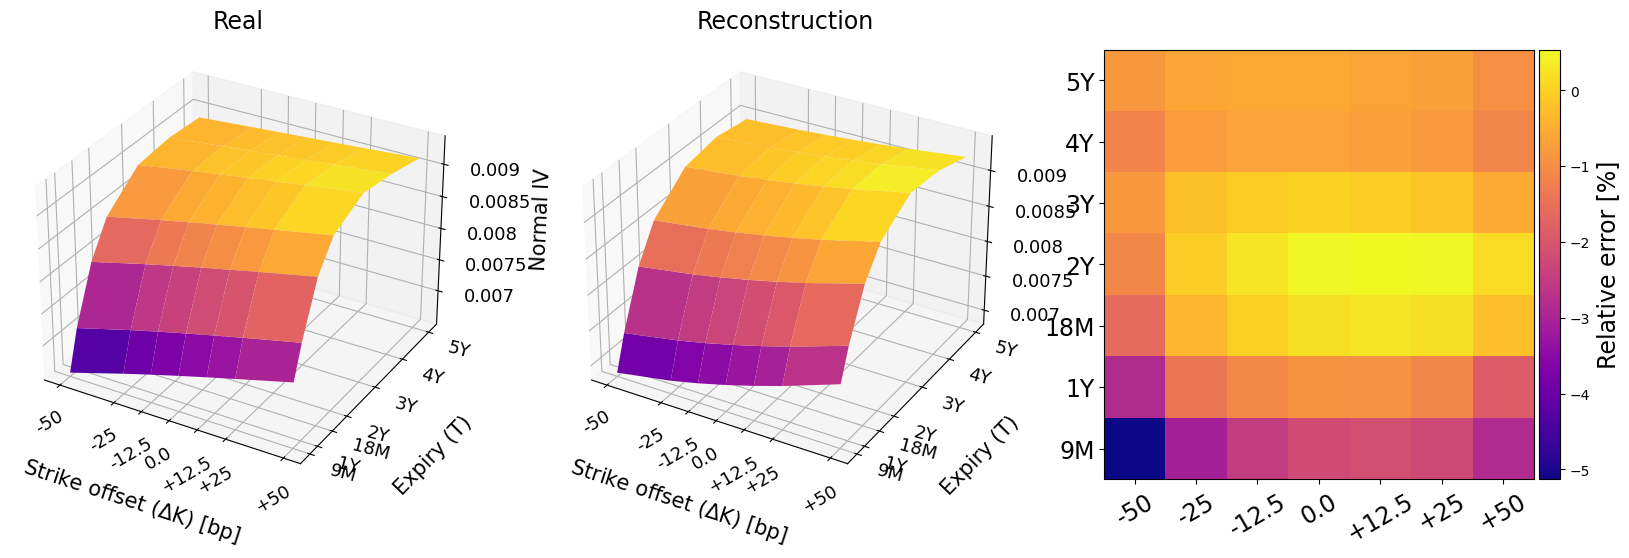

In [21]:

deltaK = np.array([-50,-25,-12.5,0.0,12.5,25,50])/10000
expiryMonths = np.array([9,12,18,24,36,48,60])
X, Y = np.meshgrid( deltaK, expiryMonths )

idx = np.random.randint( volFlat_train.shape[0] )
volsurface_flat = volFlat_train[idx:idx+1,:]
volsurface_rec_flat = ae( volsurface_flat ).numpy()

volsurface_flat = scaler.inverse_transform( volsurface_flat )
volsurface_rec_flat = scaler.inverse_transform( volsurface_rec_flat )

volsurface = volsurface_flat.reshape((7,7))
volsurface_rec = volsurface_rec_flat.reshape((7,7))

vmin = np.min( [volsurface.min(), volsurface_rec.min()] )
vmax = np.max( [volsurface.max(), volsurface_rec.max()] )

fs=20

fs=17
fs1 = 15
ts = 13
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,3,1, projection="3d")
ax.set_title("Real", fontsize=fs)
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs1, labelpad=20 )
ax.set_ylabel( "Expiry (T)", fontsize=fs1, labelpad=20 )
ax.set_zlabel( "Normal IV", fontsize=fs1, labelpad=24 )
ax.set_xticks( strikeOffsets_ )
ax.set_yticks( expiryMonths_ )
ax.set_xticklabels( ["-50","-25","-12.5","0.0","+12.5","+25","+50"], fontsize=ts, rotation=30 )
ax.set_yticklabels( ["9M","1Y","18M","2Y","3Y","4Y","5Y"], fontsize=ts, rotation=-15, verticalalignment='center', horizontalalignment='left' )
ax.plot_surface(X, Y, volsurface, cmap="plasma", vmin=vmin, vmax=vmax)
zticks = ax.get_zticks()
ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")

ax = fig.add_subplot(1,3,2, projection="3d")
ax.set_title("Reconstruction", fontsize=fs)
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs1, labelpad=20 )
ax.set_ylabel( "Expiry (T)", fontsize=fs1, labelpad=20 )
ax.set_xticks( strikeOffsets_ )
ax.set_yticks( expiryMonths_ )
ax.set_xticklabels( ["-50","-25","-12.5","0.0","+12.5","+25","+50"], fontsize=ts, rotation=30 )
ax.set_yticklabels( ["9M","1Y","18M","2Y","3Y","4Y","5Y"], fontsize=ts, rotation=-15, verticalalignment='center', horizontalalignment='left' )
ax.plot_surface(X, Y, volsurface_rec, cmap="plasma", vmin=vmin, vmax=vmax)
zticks = ax.get_zticks()
ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")

ax = fig.add_subplot(1,3,3)
res = (volsurface - volsurface_rec)/volsurface*100
im = ax.imshow( res, cmap="plasma", origin="lower" )
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels( ["-50","-25","-12.5","0.0","+12.5","+25","+50"], fontsize=fs, rotation=30 )
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels( ["9M", "1Y", "18M", "2Y", "3Y", "4Y", "5Y"], fontsize=fs )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel("Relative error [%]", fontsize=fs)



### Create a fine grid

/tmp/ipykernel_749485/2135168946.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")
/tmp/ipykernel_749485/2135168946.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")
/tmp/ipykernel_749485/2135168946.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")
/tmp/ipykernel_749485/2135168946.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")


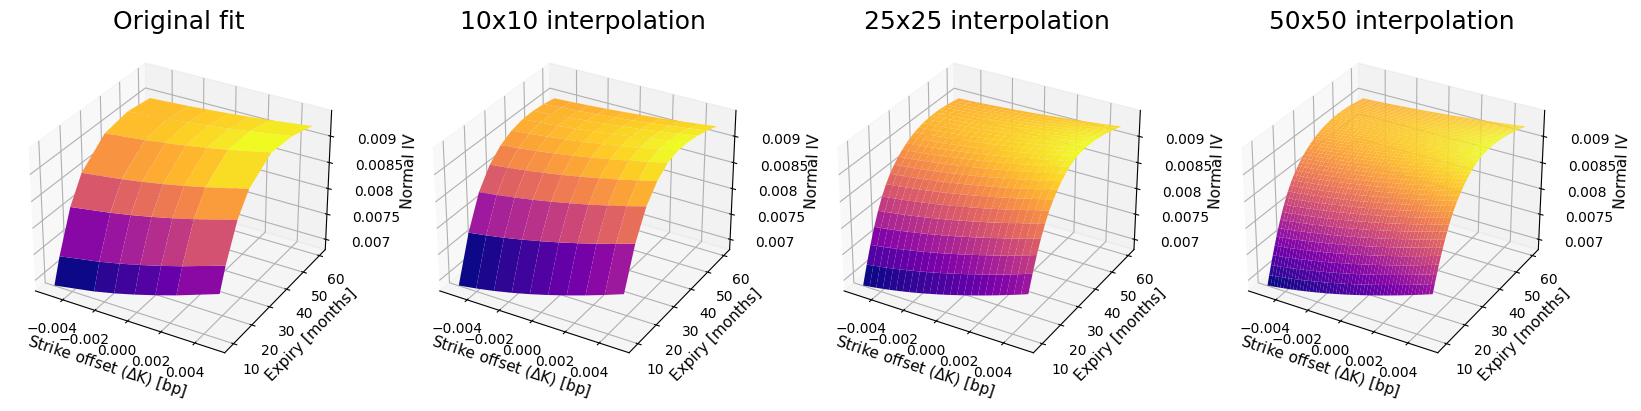

In [22]:
volsurface_flat = volFlat_train[idx:idx+1,:]
latent_space, _, _ = ae.encoder( volsurface_flat )
latent_space = latent_space.numpy()

ts = 10
fs = 11
lp = 2
lp1 = 15
fs1 = 18
fig = plt.figure(figsize=(20,10))

v = ae( volsurface_flat ).numpy().reshape((7, 7))
volsurface_rec_fine = scaler.inverse_transform(v)

ax = fig.add_subplot(1,4,1, projection="3d")
ax.set_title("Original fit", fontsize=fs1)
ax.plot_surface(X, Y, volsurface_rec_fine, cmap="plasma")
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
zticks = ax.get_zticks()
ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")

deltaK_fine = np.linspace( strikeOffsets_.min(), strikeOffsets_.max(), 10 )
expiryMonths_fine = np.linspace( expiryMonths_.min(), expiryMonths_.max(), 10 )
X_fine, Y_fine = np.meshgrid( deltaK_fine, expiryMonths_fine )
X_fine_flat = X_fine.flatten() 
Y_fine_flat = Y_fine.flatten() 

shp = X_fine_flat.shape

latent = np.tile( latent_space, (shp[0],1) )
inp = np.concatenate( [np.expand_dims(X_fine_flat, axis=-1), np.expand_dims(Y_fine_flat, axis=-1)/12., latent], axis=1 )

v = ae.decoder(inp).numpy().reshape((deltaK_fine.shape[0], expiryMonths_fine.shape[0]))
volsurface_rec_fine = scaler.inverse_transform(v)

vmin = np.min( [volsurface.min(), volsurface_rec_fine.min()] )
vmax = np.max( [volsurface.max(), volsurface_rec_fine.max()] )

ax = fig.add_subplot(1,4,2, projection="3d")
ax.set_title("10x10 interpolation", fontsize=fs1)
ax.plot_surface(X_fine, Y_fine, volsurface_rec_fine, cmap="plasma")
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
zticks = ax.get_zticks()
ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")


deltaK_fine = np.linspace( strikeOffsets_.min(), strikeOffsets_.max(), 25 )
expiryMonths_fine = np.linspace( expiryMonths_.min(), expiryMonths_.max(), 25 )
X_fine, Y_fine = np.meshgrid( deltaK_fine, expiryMonths_fine )
X_fine_flat = X_fine.flatten() 
Y_fine_flat = Y_fine.flatten() 

shp = X_fine_flat.shape

latent = np.tile( latent_space, (shp[0],1) )
inp = np.concatenate( [np.expand_dims(X_fine_flat, axis=-1), np.expand_dims(Y_fine_flat, axis=-1)/12., latent], axis=1 )

v = ae.decoder(inp).numpy().reshape((deltaK_fine.shape[0], expiryMonths_fine.shape[0]))
volsurface_rec_fine = scaler.inverse_transform(v)

vmin = np.min( [volsurface.min(), volsurface_rec_fine.min()] )
vmax = np.max( [volsurface.max(), volsurface_rec_fine.max()] )

ax = fig.add_subplot(1,4,3, projection="3d")
ax.set_title("25x25 interpolation", fontsize=fs1)
ax.plot_surface(X_fine, Y_fine, volsurface_rec_fine, cmap="plasma")
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
zticks = ax.get_zticks()
ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")


deltaK_fine = np.linspace( strikeOffsets_.min(), strikeOffsets_.max(), 50 )
expiryMonths_fine = np.linspace( expiryMonths_.min(), expiryMonths_.max(), 50 )
X_fine, Y_fine = np.meshgrid( deltaK_fine, expiryMonths_fine )
X_fine_flat = X_fine.flatten() 
Y_fine_flat = Y_fine.flatten() 

shp = X_fine_flat.shape

latent = np.tile( latent_space, (shp[0],1) )
inp = np.concatenate( [np.expand_dims(X_fine_flat, axis=-1), np.expand_dims(Y_fine_flat, axis=-1)/12., latent], axis=1 )

v = ae.decoder(inp).numpy().reshape((deltaK_fine.shape[0], expiryMonths_fine.shape[0]))
volsurface_rec_fine = scaler.inverse_transform(v)

vmin = np.min( [volsurface.min(), volsurface_rec_fine.min()] )
vmax = np.max( [volsurface.max(), volsurface_rec_fine.max()] )

ax = fig.add_subplot(1,4,4, projection="3d")
ax.set_title("50x50 interpolation", fontsize=fs1)
ax.plot_surface(X_fine, Y_fine, volsurface_rec_fine, cmap="plasma")
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
zticks = ax.get_zticks()
ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")

plt.show()

## Fitting the trained decoder model on the volsurface optimizing only in the latent space

In [23]:
def evalDecoder( x, y, z1, z2, z3 ):
    latent_inp = np.array([[z1,z2,z3]])
    latent_inp = np.tile( latent_inp, (x.shape[0],1) )
    inp = np.concatenate( [np.expand_dims(x, axis=-1), np.expand_dims(y, axis=-1), latent_inp], axis=1 )
    return ae.decoder( inp ).numpy().flatten()

def func_(inp, z1, z2, z3):
    x, y = inp
    return evalDecoder(x, y, z1, z2, z3)

In [24]:
inp = np.vstack((strikeOffsets, Ts))
func_( inp, 0, 0, 0 )

array([0.24296802, 0.27396364, 0.29341768, 0.31524955, 0.33949263,
       0.36618961, 0.42670395, 0.29023554, 0.32074064, 0.3393286 ,
       0.36013125, 0.38317716, 0.40850326, 0.46538605, 0.37826393,
       0.40605491, 0.42324947, 0.44233364, 0.46333186, 0.4862024 ,
       0.53673873, 0.45921513, 0.4843166 , 0.49973792, 0.51704258,
       0.53591328, 0.55613246, 0.60059207, 0.58452552, 0.60541345,
       0.61782734, 0.63148295, 0.64615749, 0.66180145, 0.69602111,
       0.66245364, 0.68004654, 0.69005378, 0.700776  , 0.71221491,
       0.72437322, 0.75086391, 0.70786155, 0.72226111, 0.7302658 ,
       0.73880741, 0.74788705, 0.75750656, 0.77837608])

In [25]:
idx = 42
inp = np.vstack((strikeOffsets, Ts))
popt, pcov = curve_fit( func_, xdata=inp, ydata=volFlat_train[idx,:], p0=(0,0,0), bounds=[(-10,-10,-10),(10,10,10)] )
fit = evalDecoder(strikeOffsets, Ts, *popt)
fit_ = fit.reshape((7,7))

/tmp/ipykernel_749485/4162417536.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")
/tmp/ipykernel_749485/4162417536.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")


Text(0, 0.5, 'Relative error [%]')

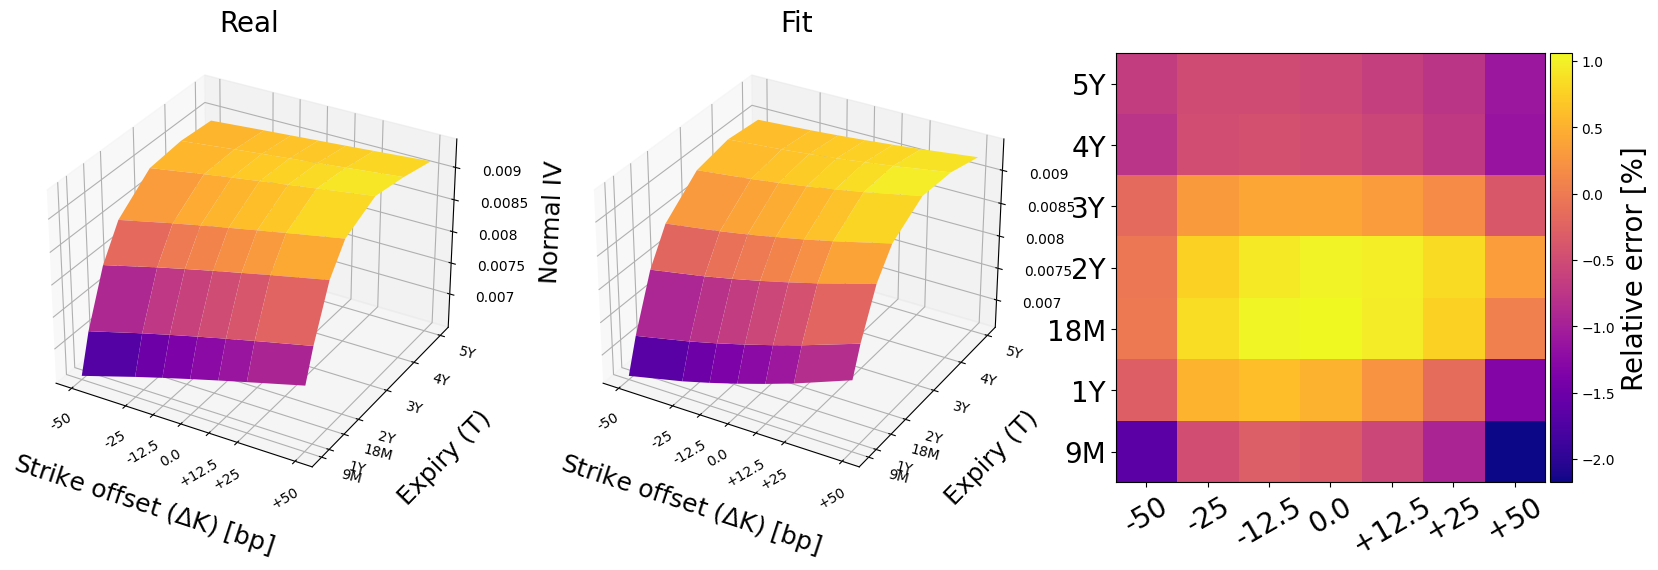

In [26]:

volsurface_flat = scaler.inverse_transform( volFlat_train[idx,:] )
volsurface_rec_flat = scaler.inverse_transform( fit )

volsurface = volsurface_flat.reshape((7,7))
volsurface_rec = volsurface_rec_flat.reshape((7,7))

vmin = np.min( [volsurface.min(), volsurface_rec.min()] )
vmax = np.max( [volsurface.max(), volsurface_rec.max()] )

fs=20

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,3,1, projection="3d")
ax.set_title("Real", fontsize=fs)
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs1, labelpad=20 )
ax.set_ylabel( "Expiry (T)", fontsize=fs1, labelpad=20 )
ax.set_zlabel( "Normal IV", fontsize=fs1, labelpad=24 )
ax.set_xticks( strikeOffsets_ )
ax.set_yticks( expiryMonths_ )
ax.set_xticklabels( ["-50","-25","-12.5","0.0","+12.5","+25","+50"], fontsize=ts, rotation=30 )
ax.set_yticklabels( ["9M","1Y","18M","2Y","3Y","4Y","5Y"], fontsize=ts, rotation=-15, verticalalignment='center', horizontalalignment='left' )
ax.plot_surface(X, Y, volsurface, cmap="plasma", vmin=vmin, vmax=vmax)
zticks = ax.get_zticks()
ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")

ax = fig.add_subplot(1,3,2, projection="3d")
ax.set_title("Fit", fontsize=fs)
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs1, labelpad=20 )
ax.set_ylabel( "Expiry (T)", fontsize=fs1, labelpad=20 )
ax.set_xticks( strikeOffsets_ )
ax.set_yticks( expiryMonths_ )
ax.set_xticklabels( ["-50","-25","-12.5","0.0","+12.5","+25","+50"], fontsize=ts, rotation=30 )
ax.set_yticklabels( ["9M","1Y","18M","2Y","3Y","4Y","5Y"], fontsize=ts, rotation=-15, verticalalignment='center', horizontalalignment='left' )
ax.plot_surface(X, Y, volsurface_rec, cmap="plasma", vmin=vmin, vmax=vmax)
zticks = ax.get_zticks()
ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")

ax = fig.add_subplot(1,3,3)
res = (volsurface - volsurface_rec)/volsurface*100
im = ax.imshow( res, cmap="plasma", origin="lower" )
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels( ["-50","-25","-12.5","0.0","+12.5","+25","+50"], fontsize=fs, rotation=30 )
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels( ["9M", "1Y", "18M", "2Y", "3Y", "4Y", "5Y"], fontsize=fs )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel("Relative error [%]", fontsize=fs)



## Investigate the meaning of the latent dimensions on the volsurfaces

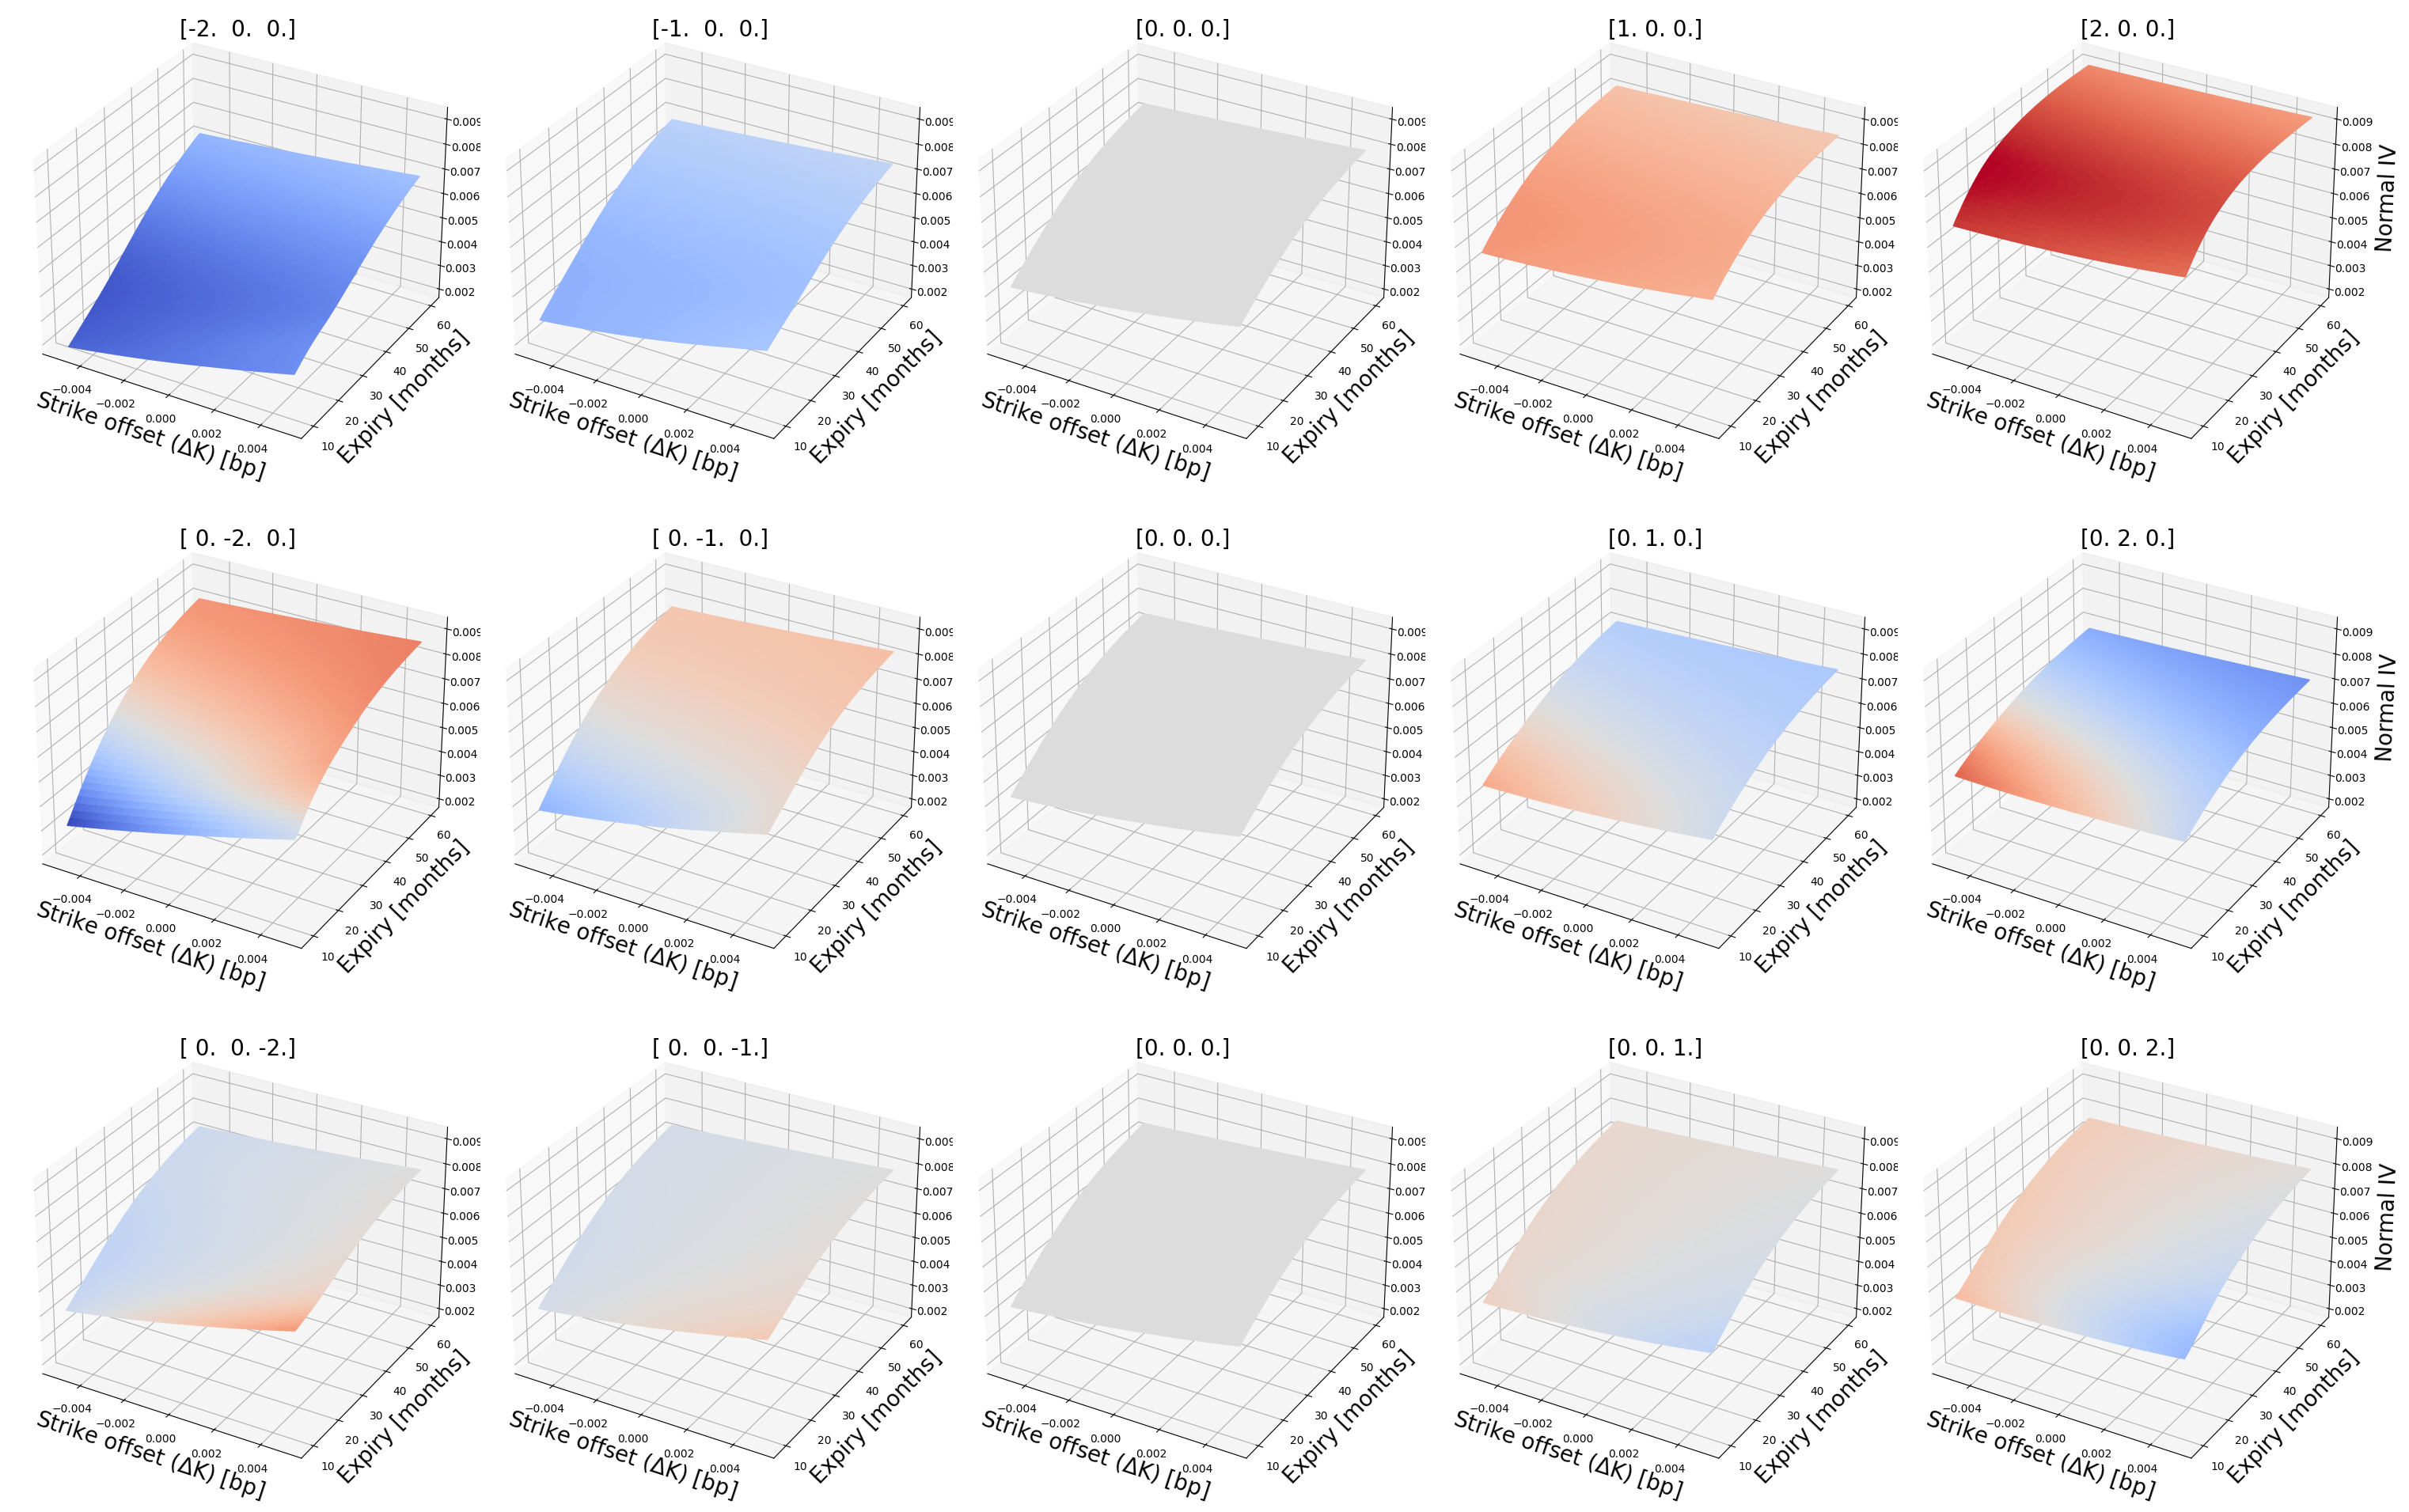

In [27]:
mean1 = 0.0
mean2 = 0.0
mean3 = 0.0

std1 = 2
std2 = 2
std3 = 2
f = 1.
range1 = [mean1 - f*std1, mean1 + f*std1]
range2 = [mean2 - f*std2, mean2 + f*std2]
range3 = [mean3 - f*std3, mean3 + f*std3]

latent_dim = 3
fig = plt.figure(figsize=(30,20))
fs = 20

lp = 5
lp1 = 10
# first coordinate
latent_coords = np.zeros( (5,latent_dim) )
latent_coords[:,0] = np.linspace(range1[0], range1[1], 5)
latent_coords[:,1] = mean2
latent_coords[:,2] = mean3
impVol_gen_list = []
for i in range(5):
    latent_ = latent_coords[i,:]
    latent_ = np.tile( latent_, (shp[0],1) )
    inp = np.concatenate( [np.expand_dims(X_fine_flat, axis=-1), np.expand_dims(Y_fine_flat, axis=-1)/12., latent_], axis=1 )
    v = ae.decoder(inp).numpy().reshape((deltaK_fine.shape[0], expiryMonths_fine.shape[0]))
    impVol_gen_list.append( scaler.inverse_transform(v) )

latent_coords1 = latent_coords
impVol_gen1 = np.array( impVol_gen_list )
diff1 = impVol_gen1 - impVol_gen1[2,:,:]


# 2nd coordinate
latent_coords = np.zeros( (5,latent_dim) )
latent_coords[:,0] = mean1
latent_coords[:,1] = np.linspace(range2[0], range2[1], 5)
latent_coords[:,2] = mean3
impVol_gen_list = []
for i in range(5):
    latent_ = latent_coords[i,:]
    latent_ = np.tile( latent_, (shp[0],1) )
    inp = np.concatenate( [np.expand_dims(X_fine_flat, axis=-1), np.expand_dims(Y_fine_flat, axis=-1)/12., latent_], axis=1 )
    v = ae.decoder(inp).numpy().reshape((deltaK_fine.shape[0], expiryMonths_fine.shape[0]))
    impVol_gen_list.append( scaler.inverse_transform(v) )

latent_coords2 = latent_coords
impVol_gen2 = np.array( impVol_gen_list )
diff2 = impVol_gen2 - impVol_gen2[2,:,:]

# 3rd coordinate
latent_coords = np.zeros( (5,latent_dim) )
latent_coords[:,0] = mean1
latent_coords[:,1] = mean2
latent_coords[:,2] = np.linspace(range3[0], range3[1], 5)
impVol_gen_list = []
for i in range(5):
    latent_ = latent_coords[i,:]
    latent_ = np.tile( latent_, (shp[0],1) )
    inp = np.concatenate( [np.expand_dims(X_fine_flat, axis=-1), np.expand_dims(Y_fine_flat, axis=-1)/12., latent_], axis=1 )
    v = ae.decoder(inp).numpy().reshape((deltaK_fine.shape[0], expiryMonths_fine.shape[0]))
    impVol_gen_list.append( scaler.inverse_transform(v) )

latent_coords3 = latent_coords
impVol_gen3 = np.array( impVol_gen_list )
diff3 = impVol_gen3 - impVol_gen3[2,:,:]

cmin = np.min( [impVol_gen1.min(), impVol_gen2.min(), impVol_gen3.min()] )
cmax = np.max( [impVol_gen1.max(), impVol_gen2.max(), impVol_gen3.max()] )
zlim = [cmin, cmax]
vmin = -np.abs(diff1).max()
vmax = np.abs(diff1).max()

ytitle = 1.005

row = 0

normalize = matplotlib.colors.Normalize(vmin, vmax)
m = plt.cm.ScalarMappable(norm=normalize, cmap='coolwarm')
m.set_array([])

ax = fig.add_subplot(latent_dim, 5, row*5 + 1, projection="3d")
color_dimension = diff1[0,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords1[0,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen1[0,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 2, projection="3d")
color_dimension = diff1[1,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords1[1,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen1[1,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 3, projection="3d")
color_dimension = diff1[2,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords1[2,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen1[2,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 4, projection="3d")
color_dimension = diff1[3,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords1[3,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen1[3,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 5, projection="3d")
color_dimension = diff1[4,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords1[4,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen1[4,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

vmin = -np.abs(diff2).max()
vmax = np.abs(diff2).max()

row = 1

normalize = matplotlib.colors.Normalize(vmin, vmax)
m = plt.cm.ScalarMappable(norm=normalize, cmap='coolwarm')
m.set_array([])

ax = fig.add_subplot(latent_dim, 5, row*5 + 1, projection="3d")
color_dimension = diff2[0,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords2[0,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen2[0,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 2, projection="3d")
color_dimension = diff2[1,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords2[1,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen2[1,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 3, projection="3d")
color_dimension = diff2[2,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords2[2,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen2[2,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 4, projection="3d")
color_dimension = diff2[3,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords2[3,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen2[3,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 5, projection="3d")
color_dimension = diff2[4,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords2[4,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen2[4,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

vmin = -np.abs(diff3).max()
vmax = np.abs(diff3).max()

row = 2
ax = fig.add_subplot(latent_dim, 5, row*5 + 1, projection="3d")
color_dimension = diff3[0,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords3[0,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen3[0,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 2, projection="3d")
color_dimension = diff3[1,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords3[1,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen3[1,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 3, projection="3d")
color_dimension = diff3[2,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords3[2,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen3[2,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 4, projection="3d")
color_dimension = diff3[3,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords3[3,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen3[3,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 5, row*5 + 5, projection="3d")
color_dimension = diff3[4,:,:]
fcolors = m.to_rgba(color_dimension)
ax.set_title(str(np.round_(latent_coords3[4,:], 2)), fontsize=fs, y=ytitle)
ax.plot_surface( X_fine, Y_fine, impVol_gen3[4,:,:], facecolors=fcolors, vmin=vmin, vmax=vmax, shade=False )
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=lp )
ax.set_ylabel( "Expiry [months]", fontsize=fs, labelpad=lp )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=lp1 )
ax.set_zlim(zlim)

fig.tight_layout()


# Generate realistic volsurfaces for further training

In [28]:
numOfRecords = 10000
latent_space_gen = np.random.normal( loc=0., scale=2.0, size=(numOfRecords, 3) )

In [29]:
encoder = tf.keras.models.load_model( "vae_encoder" )
decoder = tf.keras.models.load_model( "vae_decoder" )
ae = VAE(encoder, decoder, strikeOffsets=strikeOffsets, expiries=Ts, z_mean_ref=0., z_log_var_ref=np.log(2**2), beta=0.00005)
ae.compile()

volsurfaces_gen = ae.decode( latent_space_gen ).numpy()
volsurfaces_gen_ = scaler.inverse_transform( volsurfaces_gen )

mask = volsurfaces_gen_ > 0.0001
msk = np.all( mask, axis=1 )
volsurfaces_gen_ = volsurfaces_gen_[msk,:]
latent_space_gen = latent_space_gen[msk,:]

print(volsurfaces_gen_.min())
print(volsurfaces_gen_.max())

0.00010258518179783859
0.014494793712912905


In [30]:
volsurfaces_gen_.shape

(9954, 49)

In [33]:
volsurfaces_gen_latent = np.concatenate( [volsurfaces_gen_, latent_space_gen], axis=1 )
#np.save( outdir + "vols_latent_synth.npy", volsurfaces_gen_latent )

In [34]:
vols_latent_ = np.load( outdir + "vols_latent_synth.npy" )
vols_latent = scaler.transform( vols_latent_[:,:49] )
latent_train_ = vols_latent_[:,49:]


In [35]:
limit = int(0.8*vols_latent.shape[0])
train_set = vols_latent[ :limit, : ]
latent_train = latent_train_[ :limit, : ]
val_set = vols_latent[ limit:, : ]
latent_val = latent_train_[ limit:, : ]


## Retrain the VAE

In [232]:
encoder = tf.keras.models.load_model( "vae_encoder" )
decoder = tf.keras.models.load_model( "vae_decoder" )
ae = VAE(encoder, decoder, strikeOffsets=strikeOffsets, expiries=Ts, z_mean_ref=0., z_log_var_ref=np.log(2**2), beta=0.00005)
# freezing a network must take place BEFORE compiling the model
ae.decoder.trainable = False
ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="MeanSquaredError"
)


In [233]:
#cb1 = save_best_weights()

In [234]:
# Training the model
"""
history = ae.fit(
    x = train_set,
    y = train_set,
    epochs=30000,
    shuffle=True,
    batch_size=100,
    validation_data=(
        volFlat_train,
        volFlat_train
    ),
    callbacks=[cb1]
)
"""

'\nhistory = ae.fit(\n    x = train_set,\n    y = train_set,\n    epochs=30000,\n    shuffle=True,\n    batch_size=100,\n    validation_data=(\n        volFlat_train,\n        volFlat_train\n    ),\n    callbacks=[cb1]\n)\n'

In [235]:
#ae.set_weights( cb1.best_weights )

In [236]:
#ae.encoder.save( "vae_encoder_finetuned" )


## Generate realistic pricesurfaces for weight decoder

In [36]:
vols_gen = vols_latent_[:,:49]
print(vols_gen.min())
print(vols_gen.max())

0.00010258518179783859
0.014494793712912905


In [37]:
callFlat_rec = []
for i in range(vols_gen.shape[0]):
    c = bachelierCall_( sigma=vols_gen[i,:], F=0, K=np.array(strikeOffsets), t=0, T=np.array(Ts) )
    callFlat_rec.append(c)
callFlat_rec = np.array(callFlat_rec)
call_rec = callFlat_rec.reshape( (callFlat_rec.shape[0], 7, 7) )

putFlat_rec = []
for i in range(vols_gen.shape[0]):
    c = bachelierPut_( sigma=vols_gen[i,:], F=0, K=np.array(strikeOffsets), t=0, T=np.array(Ts) )
    putFlat_rec.append(c)
putFlat_rec = np.array(putFlat_rec)
put_rec = putFlat_rec.reshape( (putFlat_rec.shape[0], 7, 7) )

In [38]:
#np.save( outdir + "callpricesurface_gen.npy", call_rec )
#np.save( outdir + "putpricesurface_gen.npy", put_rec )

## Calculate and save the reconstructed volsurfaces

In [39]:
encoder = tf.keras.models.load_model( "vae_encoder" )
decoder = tf.keras.models.load_model( "vae_decoder" )
ae = VAE(encoder, decoder, strikeOffsets=strikeOffsets, expiries=Ts, z_mean_ref=0., z_log_var_ref=0., beta=0.00005)
ae.compile()

volFlat_latent, _, _ = ae.encoder(volFlat_train_)
volFlat_latent = volFlat_latent.numpy()

volFlat_rec = ae.decode( volFlat_latent )
volFlat_rec = scaler.inverse_transform( volFlat_rec )

volsurfaces_latent = np.concatenate( [volFlat_rec, volFlat_latent], axis=1 )

#np.save( outdir + "vols_latent_real.npy", volsurfaces_latent )


In [40]:
callFlat_rec = []
for i in range(volFlat_rec.shape[0]):
    c = bachelierCall_( sigma=volFlat_rec[i,:], F=0, K=np.array(strikeOffsets), t=0, T=np.array(Ts) )
    callFlat_rec.append(c)
callFlat_rec = np.array(callFlat_rec)
call_rec = callFlat_rec.reshape( (callFlat_rec.shape[0], 7, 7) )

putFlat_rec = []
for i in range(volFlat_rec.shape[0]):
    c = bachelierPut_( sigma=volFlat_rec[i,:], F=0, K=np.array(strikeOffsets), t=0, T=np.array(Ts) )
    putFlat_rec.append(c)
putFlat_rec = np.array(putFlat_rec)
put_rec = putFlat_rec.reshape( (putFlat_rec.shape[0], 7, 7) )

In [41]:
#np.save( outdir + "callpricesurface_real_interp.npy", call_rec )
#np.save( outdir + "putpricesurface_real_interp.npy", put_rec )

# Weighted Monte Carlo

In [42]:
# generate the path set
def generate_paths(scale, numOfSteps, numOfPaths, seed=42):
    np.random.seed(seed)
    dt = 5./numOfSteps
    W = np.random.normal( loc=0., scale=scale*np.sqrt(dt), size=(numOfPaths, numOfSteps) )
    W0 = np.concatenate( [np.zeros( shape=(numOfPaths,1)), np.cumsum( W, axis=1 )], axis=1 )
    return W0

# the maximum implied volatility in the used GBP swaption data
maxvol = 0.009377

scale = maxvol
numOfPaths = 20000
numOfSteps = 25000
W0 = generate_paths( scale=scale, numOfSteps=numOfSteps, numOfPaths=numOfPaths )
np.save( outdir + "W0_12_15_25000.npy", W0 )

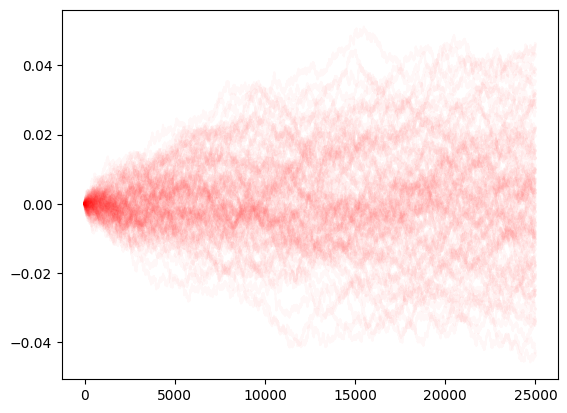

In [43]:
idx = np.random.randint(0,W0.shape[0], 100)
for i in idx:
    plt.plot( W0[i,:], c="red", alpha=0.03 )

## Build the weight decoder model

In [44]:
class Decoder(keras.Model):
    def __init__(self, payoff_mtx_call, payoff_mtx_put, strikeOffsets, beta=1., **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.payoff_mtx_call = payoff_mtx_call
        self.payoff_mtx_put = payoff_mtx_put
        self.strikeOffsets = strikeOffsets
        self.numOfPaths = tf.constant( self.payoff_mtx_call.shape[0], dtype=tf.float64 )
        self.beta = beta
        inputs = keras.Input(shape=(3,))
        x = layers.Dense(20, activation="elu")(inputs)
        x = layers.Dense(49, activation="elu")(x)
        x = layers.Dense(self.payoff_mtx_call.shape[0], activation="softmax")(x)
        self.model = keras.Model(inputs, x, name="model")
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
        ]
    
    # this returns with the probabilities
    def call(self, inp):
        return self.model( inp )
    
    def impsamp( self, p, payoff_mtx ):
        option_prices = tf.tensordot( p, payoff_mtx, axes=(1,0))

        return option_prices

    def train_step(self, data_):
        latent, labels = data_
        callprices_real, putprices_real = labels
        latent = tf.convert_to_tensor(latent, dtype=tf.float64)
        shp = tf.shape(latent)
        strikeMtx = tf.tile( self.strikeOffsets, (shp[0],1) )
        tmp = np.ones( (1,49) )
        tmp = tf.tile( tmp, (shp[0],1) )
        with tf.GradientTape() as tape:
            p = self.model( latent )
            callprices_rec = self.impsamp( p, self.payoff_mtx_call )
            putprices_rec = strikeMtx + callprices_rec
            # calculate losses

            #put extra penalty on the (9M, -50bp) point of the pricesurface
            callprices_diff = (callprices_real - callprices_rec)**2
            putprices_diff = (putprices_real - putprices_rec)**2
            callprices_diff = callprices_diff*tmp
            putprices_diff = putprices_diff*tmp
            callprices_rec_loss = tf.math.reduce_mean( callprices_diff )
            putprices_rec_loss = tf.math.reduce_mean( putprices_diff )
            
            pc_parity_loss = tf.math.reduce_mean( (callprices_rec-putprices_rec+strikeMtx)**2 )
            rel_entropy = tf.math.log(self.numOfPaths) + tf.math.reduce_sum( p*tf.math.log(p), axis=1 )
            rel_entropy = tf.math.reduce_mean( rel_entropy, axis=0 )
            
            total_loss = callprices_rec_loss + putprices_rec_loss + self.beta*rel_entropy
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "pc_parity_loss": pc_parity_loss,
            "callprices_rec_loss": callprices_rec_loss,
            "putprices_rec_loss": putprices_rec_loss,
            "rel_entropy": rel_entropy
        }
    
    def test_step(self, data_):
        latent, labels = data_
        callprices_real, putprices_real = labels
        latent = tf.convert_to_tensor(latent, dtype=tf.float64)
        shp = tf.shape(latent)
        strikeMtx = tf.tile( self.strikeOffsets, (shp[0],1) )
        tmp = np.ones( (1,49) )
        tmp = tf.tile( tmp, (shp[0],1) )
        p = self.model( latent )
        callprices_rec = self.impsamp( p, self.payoff_mtx_call )
        putprices_rec = strikeMtx + callprices_rec
        # calculate losses

        #put extra penalty on the (9M, -50bp) point of the pricesurface
        callprices_diff = (callprices_real - callprices_rec)**2
        putprices_diff = (putprices_real - putprices_rec)**2
        callprices_diff = callprices_diff*tmp
        putprices_diff = putprices_diff*tmp
        callprices_rec_loss = tf.math.reduce_mean( callprices_diff )
        putprices_rec_loss = tf.math.reduce_mean( putprices_diff )

        pc_parity_loss = tf.math.reduce_mean( (callprices_rec-putprices_rec+strikeMtx)**2 )
        rel_entropy = tf.math.log(self.numOfPaths) + tf.math.reduce_sum( p*tf.math.log(p), axis=1 )
        rel_entropy = tf.math.reduce_mean( rel_entropy, axis=0 )

        total_loss = callprices_rec_loss + putprices_rec_loss + self.beta*rel_entropy
        return {
            "loss": total_loss,
            "pc_parity_loss": pc_parity_loss,
            "callprices_rec_loss": callprices_rec_loss,
            "putprices_rec_loss": putprices_rec_loss,
            "rel_entropy": rel_entropy
        }


### Load training data

In [45]:
vols_latent_ = np.load( outdir + "vols_latent_synth.npy" )
latent_space = vols_latent_[:,49:]

callpricesurfaceArr = np.load( outdir + "callpricesurface_gen.npy" )
putpricesurfaceArr = np.load( outdir + "putpricesurface_gen.npy" )

W0 = np.load( outdir + "W0_12_15_25000.npy" )

deltaK = np.array([-50,-25,-12.5,0.0,12.5,25,50])/10000
strikeOffsets_ = deltaK.copy()
expiryMonths_ = np.array([9,12,18,24,36,48,60])
Ts_ = expiryMonths_/12.
strikeOffsetsMtx, expiryMonthsMtx = np.meshgrid( strikeOffsets_, expiryMonths_ )
strikeOffsets = strikeOffsetsMtx.flatten()
expiryMonths = expiryMonthsMtx.flatten()
Ts = expiryMonths / 12.
F0 = 0.0
Ks = F0 + strikeOffsets

idOfEnd_ = ((expiryMonths_ / 60.)*W0.shape[1]).astype(int) - 1
idOfEnd = ((expiryMonths / 60.)*W0.shape[1]).astype(int) - 1

expiryMonths = np.array([9,12,18,24,36,48,60])
X, Y = np.meshgrid( deltaK, expiryMonths )

shp = callpricesurfaceArr.shape

callpricesFlat = callpricesurfaceArr.reshape( (shp[0], shp[1]*shp[2]) )
putpricesFlat = putpricesurfaceArr.reshape( (shp[0], shp[1]*shp[2]) )

shp = volsurfaces.shape
volFlat_ = volsurfaces.reshape( (shp[0], shp[1]*shp[2]) )

volFlat_val = np.load( outdir + "vols_latent_real.npy" )[:,:49]
latent_val = np.load( outdir + "vols_latent_real.npy" )[:,49:]

callprices_val = np.load(outdir + "callpricesurface_real_interp.npy")
putprices_val = np.load(outdir + "putpricesurface_real_interp.npy")

shp = callprices_val.shape

callpricesFlat_val = callprices_val.reshape( (shp[0], shp[1]*shp[2]) )
putpricesFlat_val = putprices_val.reshape( (shp[0], shp[1]*shp[2]) )

### Define payoff matrices

In [46]:
signs = np.tile( [1,1,1,1,1,1,1], (7, 1) ).flatten()
payoff_mtx_call = np.empty( (W0.shape[0], strikeOffsets.shape[0])  )

for j in range(strikeOffsets.shape[0]):
    payoff_mtx_call[:,j] = np.maximum( signs[j]*(W0[:,idOfEnd[j]] - strikeOffsets[j]), 0 )

signs = np.tile( [-1,-1,-1,-1,-1,-1,-1], (7, 1) ).flatten()
payoff_mtx_put = np.empty( (W0.shape[0], strikeOffsets.shape[0])  )

for j in range(strikeOffsets.shape[0]):
    payoff_mtx_put[:,j] = np.maximum( signs[j]*(W0[:,idOfEnd[j]] - strikeOffsets[j]), 0 )


In [47]:
cb2 = save_best_weights()

In [48]:
decoder = Decoder(payoff_mtx_call, payoff_mtx_put, np.expand_dims(strikeOffsets, axis=0), beta=0.00000001)
decoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="MeanSquaredError"
)


### Loading the trained model

In [49]:
decoder.model = tf.keras.models.load_model( "weight_decoder" )
decoder.model.compile()


In [ ]:
# Training the model
"""
history = decoder.fit(
    x = latent_space,
    y = (callpricesFlat, putpricesFlat),
    epochs=30000,
    shuffle=True,
    batch_size=100,
    validation_data=(
        latent_val,
        (callpricesFlat_val, putpricesFlat_val)
    ),
    callbacks=[cb2]
)
"""

In [250]:
#decoder.set_weights( cb2.best_weights )

In [50]:
decoder.evaluate(
    x = latent_space,
    y = (callpricesFlat, putpricesFlat),
)

312/312 [==============================] - 2s 7ms/step - loss: 1.1876e-08 - pc_parity_loss: 8.5237e-38 - callprices_rec_loss: 2.3794e-09 - putprices_rec_loss: 2.3794e-09 - rel_entropy: 0.7118


[1.7989542419878086e-09,
 7.52365241881285e-09,
 1.0171624586707142e-37,
 1.7989542419878146e-09,
 0.3925743934837227]

## Check the effect of the latent space on the risk neutral densities

In [51]:
bin_edges = np.linspace( -0.04, 0.04, 40 )
bin_centers = bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2

forwardMtx, expiryMonthsMtx2 = np.meshgrid( bin_centers, expiryMonths_ )


(0.0, 109.11725411942734)

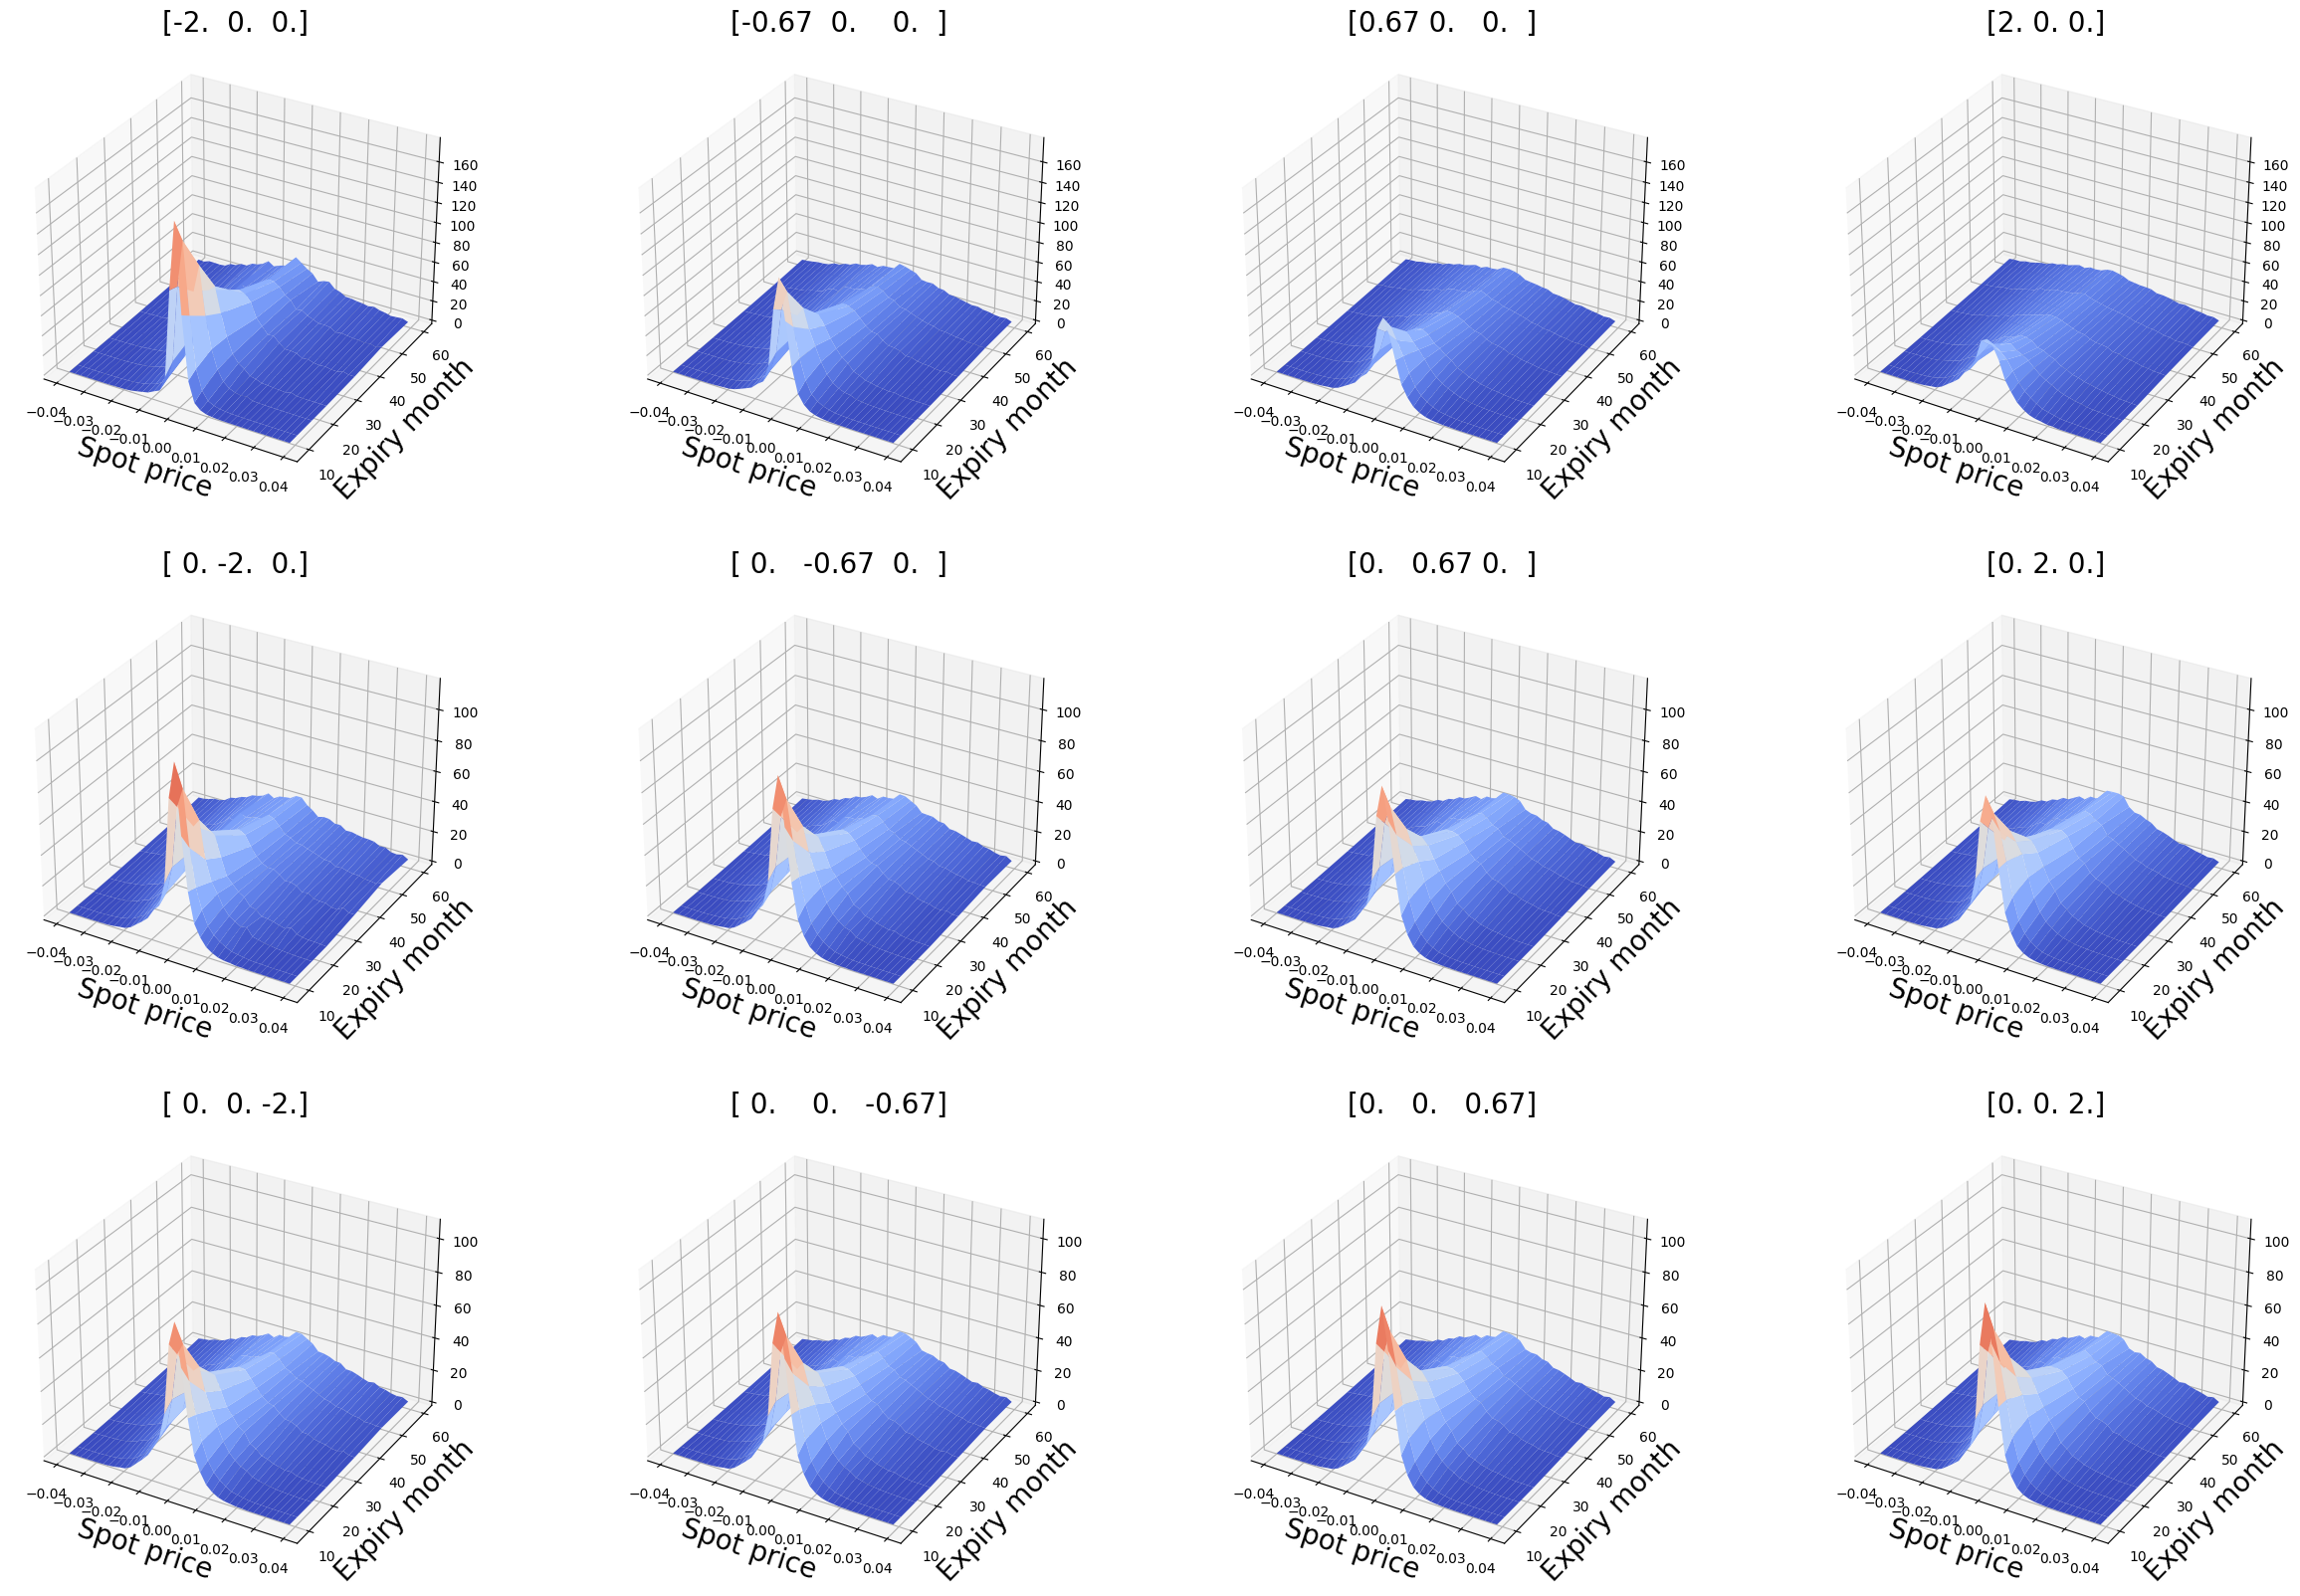

In [52]:
fig = plt.figure(figsize=(30,20))

# first coordinate
latent_coords = np.zeros( (4,latent_dim) )
latent_coords[:,0] = np.linspace(range1[0], range1[1], 4)
latent_coords[:,1] = mean2
latent_coords[:,2] = mean3

ps = decoder( latent_coords ).numpy()
rnd_list = []
for k in range(4):
    p = ps[k,:]
    hist_list = []
    for i in idOfEnd_:
        hist_list.append( np.histogram( W0[:,i], bins=bin_edges, weights=p.flatten(), density=True)[0] )
    hist = np.array( hist_list )
    rnd_list.append( hist )
rnd = np.array( rnd_list )
    
cmin = np.min( rnd )
cmax = np.max( rnd )
zlim = [cmin, cmax]

ax = fig.add_subplot(latent_dim, 4, 1, projection="3d")
ax.set_title(str(np.round_(latent_coords[0,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[0,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 4, 2, projection="3d")
ax.set_title(str(np.round_(latent_coords[1,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[1,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 4, 3, projection="3d")
ax.set_title(str(np.round_(latent_coords[2,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[2,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 4, 4, projection="3d")
ax.set_title(str(np.round_(latent_coords[3,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[3,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

# second coordinate
latent_coords = np.zeros( (4,latent_dim) )
latent_coords[:,0] = mean1
latent_coords[:,1] = np.linspace(range2[0], range2[1], 4)
latent_coords[:,2] = mean3

ps = decoder( latent_coords ).numpy()
rnd_list = []
for k in range(4):
    p = ps[k,:]
    hist_list = []
    for i in idOfEnd_:
        hist_list.append( np.histogram( W0[:,i], bins=bin_edges, weights=p.flatten(), density=True)[0] )
    hist = np.array( hist_list )
    rnd_list.append( hist )
rnd = np.array( rnd_list )
    
cmin = np.min( rnd )
cmax = np.max( rnd )
zlim = [cmin, cmax]

ax = fig.add_subplot(latent_dim, 4, 5, projection="3d")
ax.set_title(str(np.round_(latent_coords[0,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[0,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 4, 6, projection="3d")
ax.set_title(str(np.round_(latent_coords[1,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[1,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 4, 7, projection="3d")
ax.set_title(str(np.round_(latent_coords[2,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[2,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 4, 8, projection="3d")
ax.set_title(str(np.round_(latent_coords[3,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[3,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

# third coordinate
latent_coords = np.zeros( (4,latent_dim) )
latent_coords[:,0] = mean1
latent_coords[:,1] = mean2
latent_coords[:,2] = np.linspace(range3[0], range3[1], 4)

ps = decoder( latent_coords ).numpy()
rnd_list = []
for k in range(4):
    p = ps[k,:]
    hist_list = []
    for i in idOfEnd_:
        hist_list.append( np.histogram( W0[:,i], bins=bin_edges, weights=p.flatten(), density=True)[0] )
    hist = np.array( hist_list )
    rnd_list.append( hist )
rnd = np.array( rnd_list )
    
cmin = np.min( rnd )
cmax = np.max( rnd )
zlim = [cmin, cmax]

ax = fig.add_subplot(latent_dim, 4, 9, projection="3d")
ax.set_title(str(np.round_(latent_coords[0,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[0,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 4, 10, projection="3d")
ax.set_title(str(np.round_(latent_coords[1,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[1,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 4, 11, projection="3d")
ax.set_title(str(np.round_(latent_coords[2,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[2,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)

ax = fig.add_subplot(latent_dim, 4, 12, projection="3d")
ax.set_title(str(np.round_(latent_coords[3,:], 2)), fontsize=fs)
ax.plot_surface( forwardMtx, expiryMonthsMtx2, rnd[3,:,:], cmap=cm.coolwarm, vmin=cmin, vmax=cmax )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylabel("Expiry month", fontsize=fs)
ax.set_zlim(zlim)


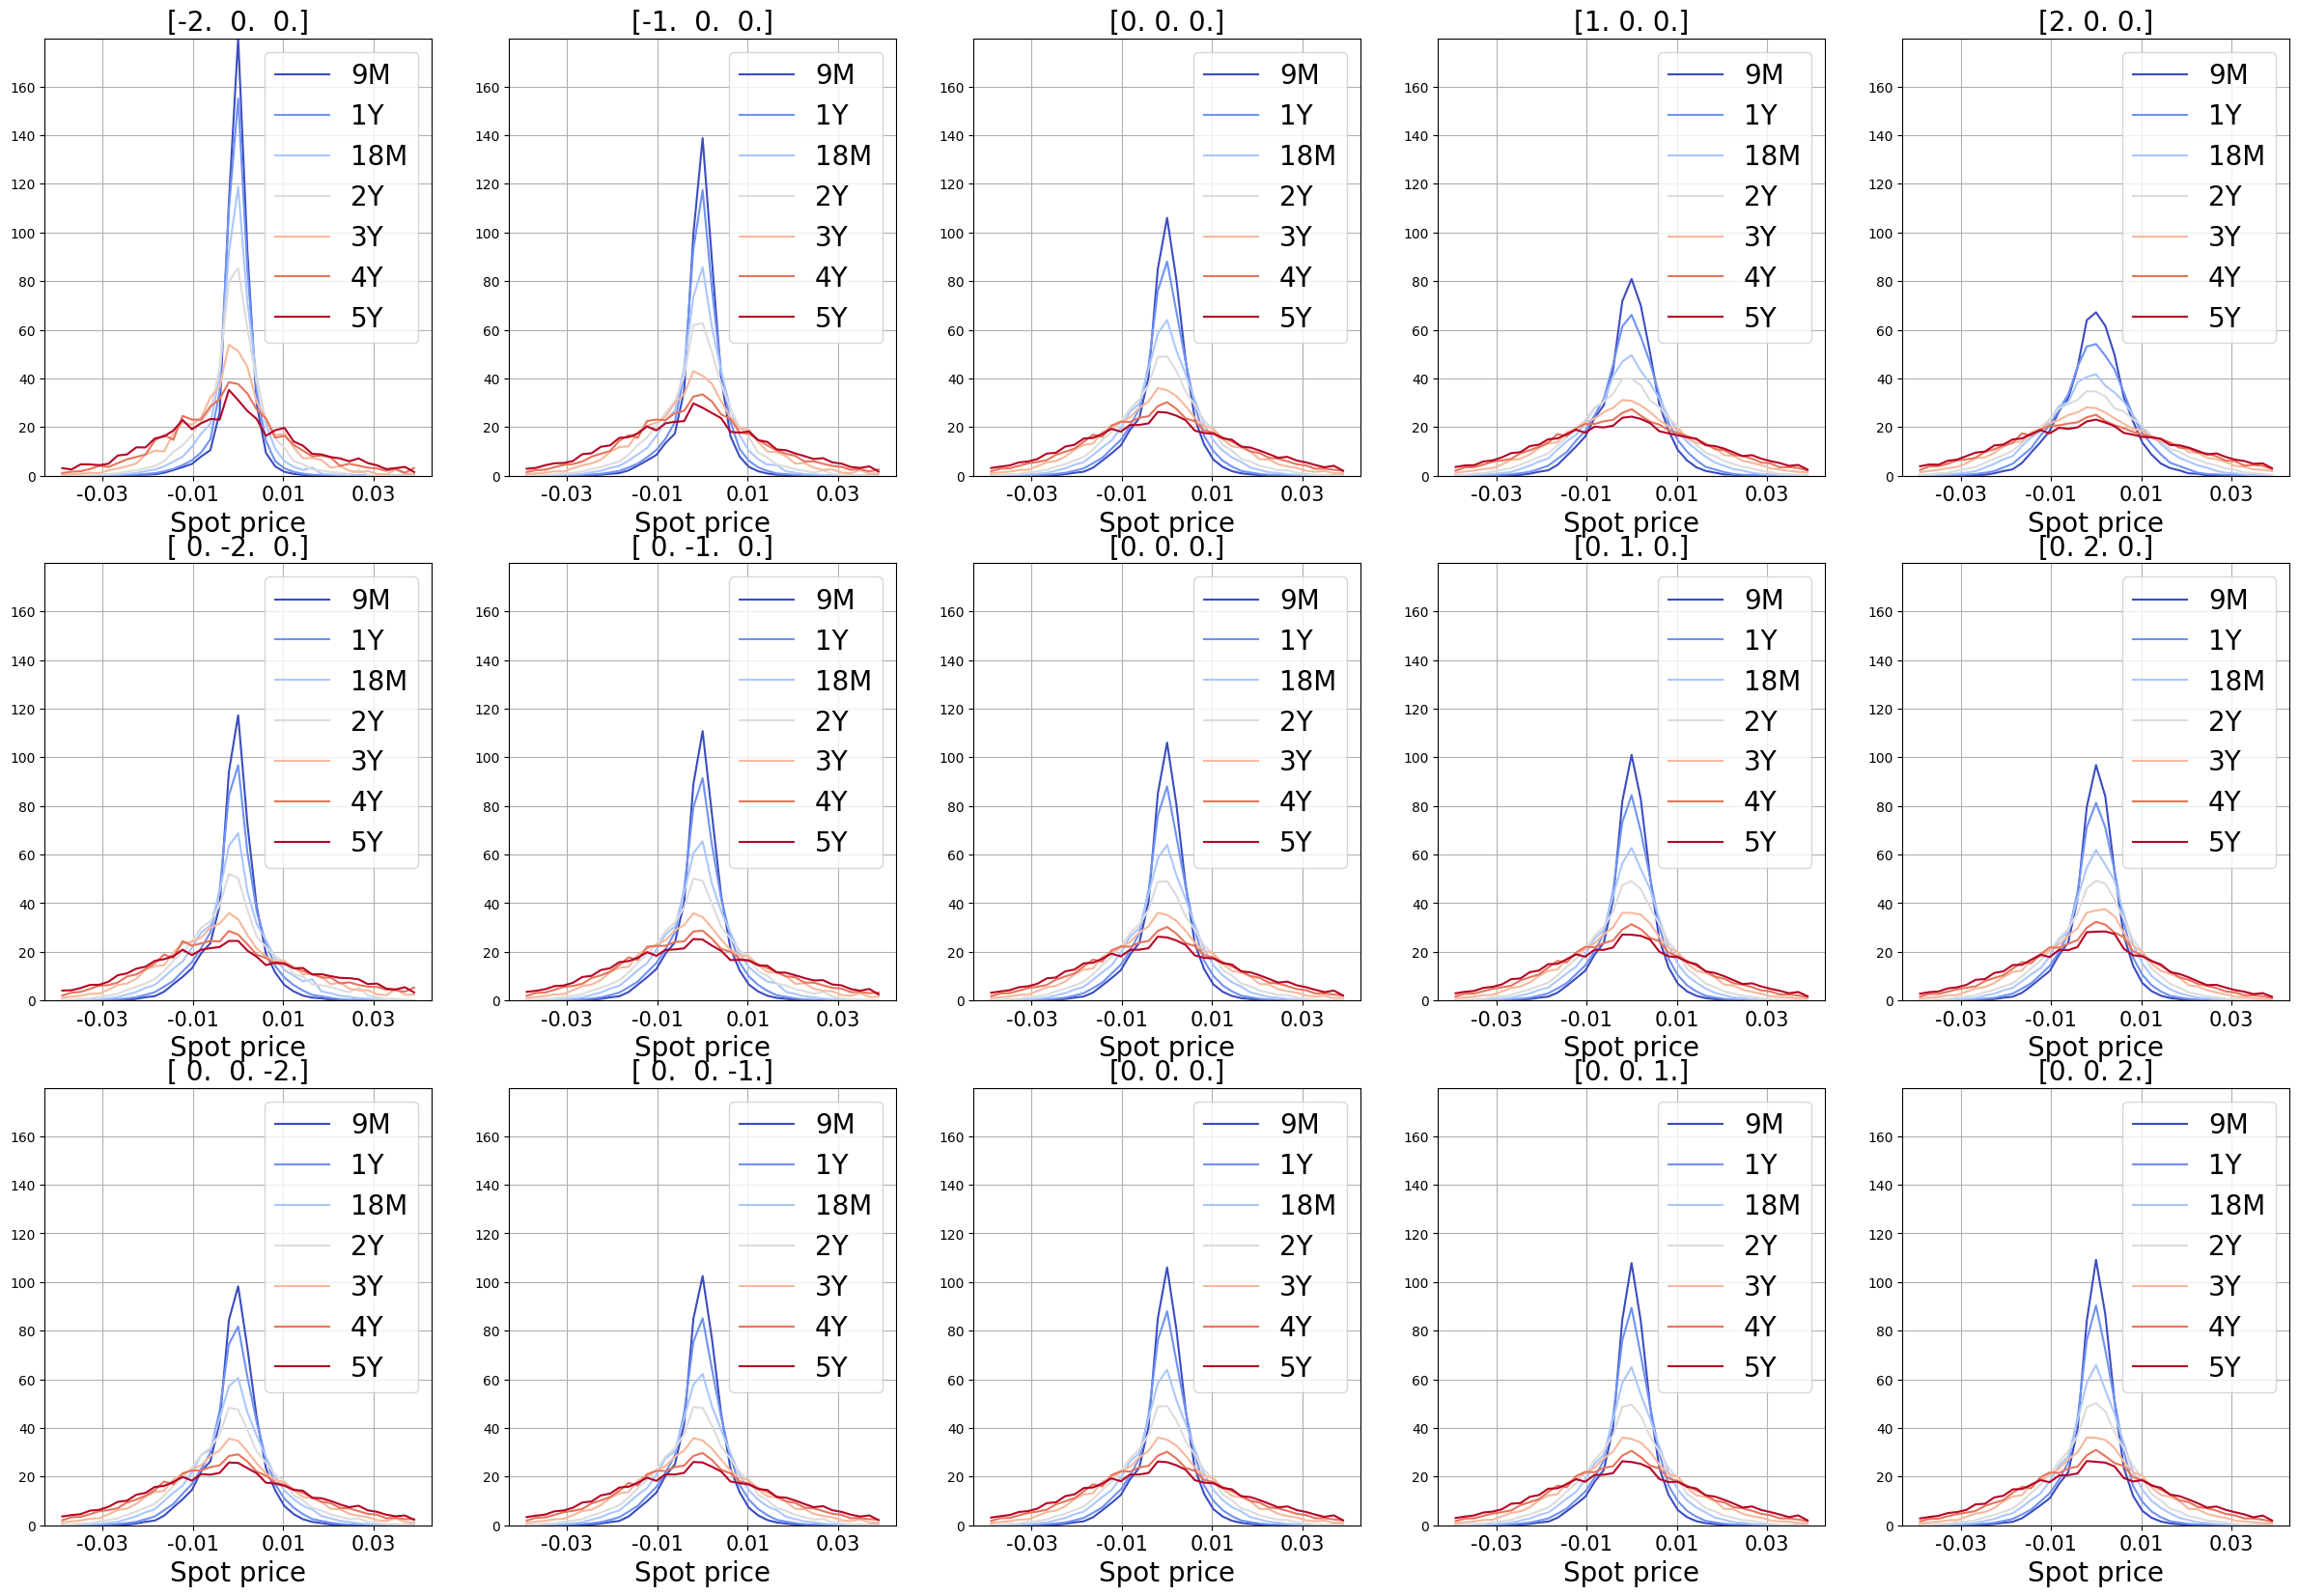

In [53]:
expiriesStr = ["9M", "1Y", "18M", "2Y", "3Y", "4Y", "5Y"]
cm.coolwarm(10)
colors = cm.coolwarm((np.linspace(0,1,7)))

fig = plt.figure(figsize=(30,20))
fs = 20

xticks = np.array([-0.03,-0.01,0.01,0.03])
lp = 5
lp1 = 10
ts = 15
# first coordinate
latent_coords = np.zeros( (5,latent_dim) )
latent_coords[:,0] = np.linspace(range1[0], range1[1], 5)
latent_coords[:,1] = mean2
latent_coords[:,2] = mean3

ps = decoder( latent_coords ).numpy()
rnd_list = []
for k in range(5):
    p = ps[k,:]
    hist_list = []
    for i in idOfEnd_:
        hist_list.append( np.histogram( W0[:,i], bins=bin_edges, weights=p.flatten(), density=True)[0] )
    hist = np.array( hist_list )
    rnd_list.append( hist )
rnd1 = np.array( rnd_list )
latent_coords1 = latent_coords

# 2nd coordinate
latent_coords = np.zeros( (5,latent_dim) )
latent_coords[:,0] = mean1
latent_coords[:,1] = np.linspace(range2[0], range2[1], 5)
latent_coords[:,2] = mean3

ps = decoder( latent_coords ).numpy()
rnd_list = []
for k in range(5):
    p = ps[k,:]
    hist_list = []
    for i in idOfEnd_:
        hist_list.append( np.histogram( W0[:,i], bins=bin_edges, weights=p.flatten(), density=True)[0] )
    hist = np.array( hist_list )
    rnd_list.append( hist )
rnd2 = np.array( rnd_list )
latent_coords2 = latent_coords

# 3rd coordinate
latent_coords = np.zeros( (5,latent_dim) )
latent_coords[:,0] = mean1
latent_coords[:,1] = mean2
latent_coords[:,2] = np.linspace(range3[0], range3[1], 5)

ps = decoder( latent_coords ).numpy()
rnd_list = []
for k in range(5):
    p = ps[k,:]
    hist_list = []
    for i in idOfEnd_:
        hist_list.append( np.histogram( W0[:,i], bins=bin_edges, weights=p.flatten(), density=True)[0] )
    hist = np.array( hist_list )
    rnd_list.append( hist )
rnd3 = np.array( rnd_list )
latent_coords3 = latent_coords

cmin = np.min( [rnd1.min(), rnd2.min(), rnd3.min()] )
cmax = np.max( [rnd1.max(), rnd2.max(), rnd3.max()] )
ylim = [cmin, cmax]

#first coordinate

row = 0
ax = fig.add_subplot(latent_dim, 5, 5*row+1)
ax.set_title(str(np.round_(latent_coords1[0,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd1[0,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+2)
ax.set_title(str(np.round_(latent_coords1[1,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd1[1,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+3)
ax.set_title(str(np.round_(latent_coords1[2,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd1[2,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+4)
ax.set_title(str(np.round_(latent_coords1[3,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd1[3,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+5)
ax.set_title(str(np.round_(latent_coords1[4,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd1[4,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

# second coordinate
row=1
ax = fig.add_subplot(latent_dim, 5, 5*row+1)
ax.set_title(str(np.round_(latent_coords2[0,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd2[0,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+2)
ax.set_title(str(np.round_(latent_coords2[1,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd2[1,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+3)
ax.set_title(str(np.round_(latent_coords2[2,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd2[2,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+4)
ax.set_title(str(np.round_(latent_coords2[3,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd2[3,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+5)
ax.set_title(str(np.round_(latent_coords2[4,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd2[4,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

# third coordinate
row=2
ax = fig.add_subplot(latent_dim, 5, 5*row+1)
ax.set_title(str(np.round_(latent_coords3[0,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd3[0,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+2)
ax.set_title(str(np.round_(latent_coords3[1,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd3[1,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+3)
ax.set_title(str(np.round_(latent_coords3[2,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd3[2,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+4)
ax.set_title(str(np.round_(latent_coords3[3,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd3[3,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()

ax = fig.add_subplot(latent_dim, 5, 5*row+5)
ax.set_title(str(np.round_(latent_coords3[4,:], 2)), fontsize=fs)
for i in range(0,7):
    ax.plot( bin_centers, rnd3[4,i,:], label=expiriesStr[i], c=colors[i] )
ax.set_xlabel("Spot price", fontsize=fs)
ax.set_ylim(ylim)
ax.set_xticks(xticks)
ax.xaxis.set_ticklabels(xticks, fontsize=ts)
ax.legend(fontsize=fs)
ax.grid()


## Reproduce a volatility surface using the weight decoder

1.0


/tmp/ipykernel_749485/703012583.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")


Text(0, 0.5, 'Relative error [%]')

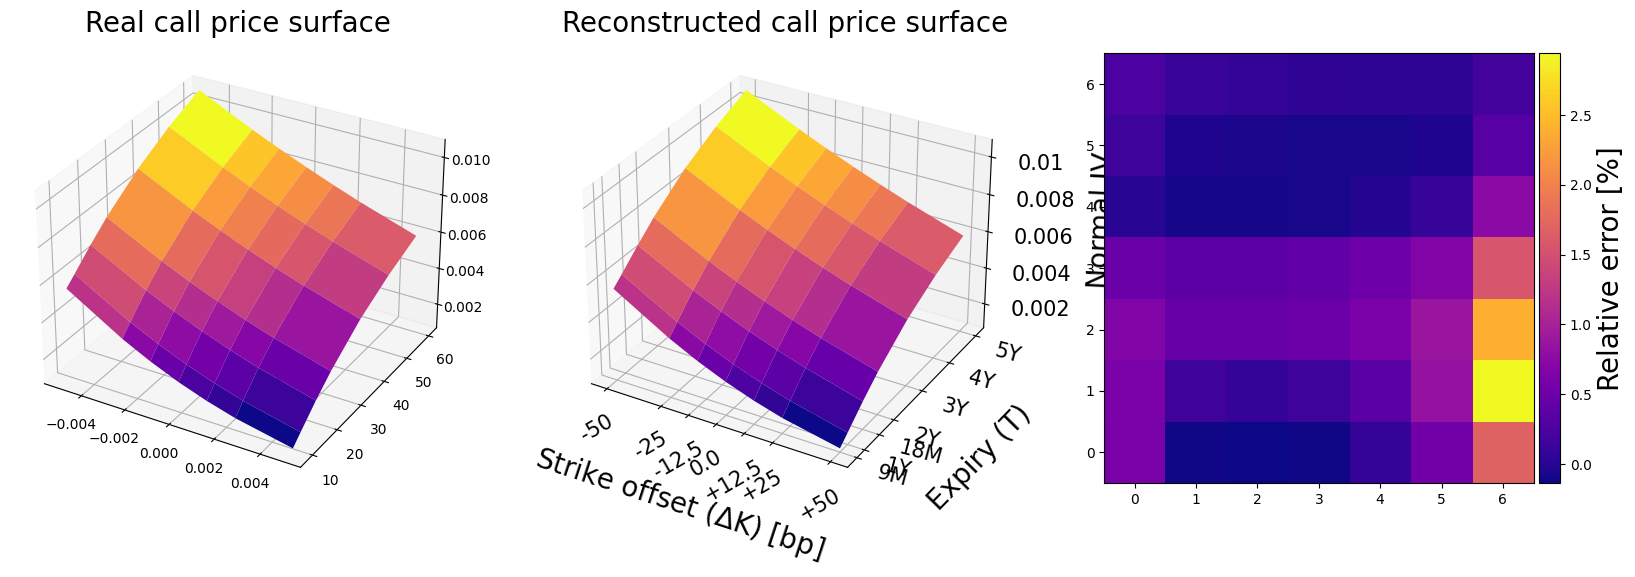

In [54]:
idx = 42

latent = latent_val[idx:idx+1,:]
p = decoder( latent ).numpy()
print(p.sum())
option_prices_rec_flat = decoder.impsamp( p, decoder.payoff_mtx_call ).numpy().flatten()
option_prices_flat = callpricesFlat_val[idx,...].flatten()

option_prices_rec = option_prices_rec_flat.reshape((7,7))
option_prices = option_prices_flat.reshape((7,7))

fs=20
ts=15

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,3,1, projection="3d")
ax.set_title("Real call price surface", fontsize=fs)
ax.plot_surface(X, Y, option_prices, cmap="plasma")

ax = fig.add_subplot(1,3,2, projection="3d")
ax.set_title("Reconstructed call price surface", fontsize=fs)
ax.plot_surface(X, Y, option_prices_rec, cmap="plasma")
ax.set_xlabel( r"Strike offset ($\Delta$K) [bp]", fontsize=fs, labelpad=20 )
ax.set_ylabel( "Expiry (T)", fontsize=fs, labelpad=20 )
ax.set_zlabel( "Normal IV", fontsize=fs, labelpad=30 )
ax.set_xticks( strikeOffsets_ )
ax.set_yticks( expiryMonths_ )
ax.set_xticklabels( ["-50","-25","-12.5","0.0","+12.5","+25","+50"], fontsize=ts, rotation=30 )
ax.set_yticklabels( ["9M","1Y","18M","2Y","3Y","4Y","5Y"], fontsize=ts, rotation=-15, verticalalignment='center', horizontalalignment='left' )
zticks = ax.get_zticks()
ax.set_zticklabels( list(np.around(zticks, 4).astype(str)), fontsize=ts, horizontalalignment="left")

ax = fig.add_subplot(1,3,3)
res = (option_prices - option_prices_rec)/option_prices*100
im = ax.imshow( res, cmap="plasma", origin="lower" )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel("Relative error [%]", fontsize=fs)



### Calculate the implied volatilites from the reconstructed price surface

In [55]:
def objFunc1( sigma, F, K, t, T, C ):
    return C - bachelierPut_( sigma, F, K, t, T )

def objFunc2( sigma, F, K, t, T, C ):
    return C - bachelierCall_( sigma, F, K, t, T )

objFuncs = np.tile( [objFunc2,objFunc2,objFunc2,objFunc2,objFunc2,objFunc2,objFunc2], (7, 1) ).flatten()


Text(0, 0.5, 'Relative error [%]')

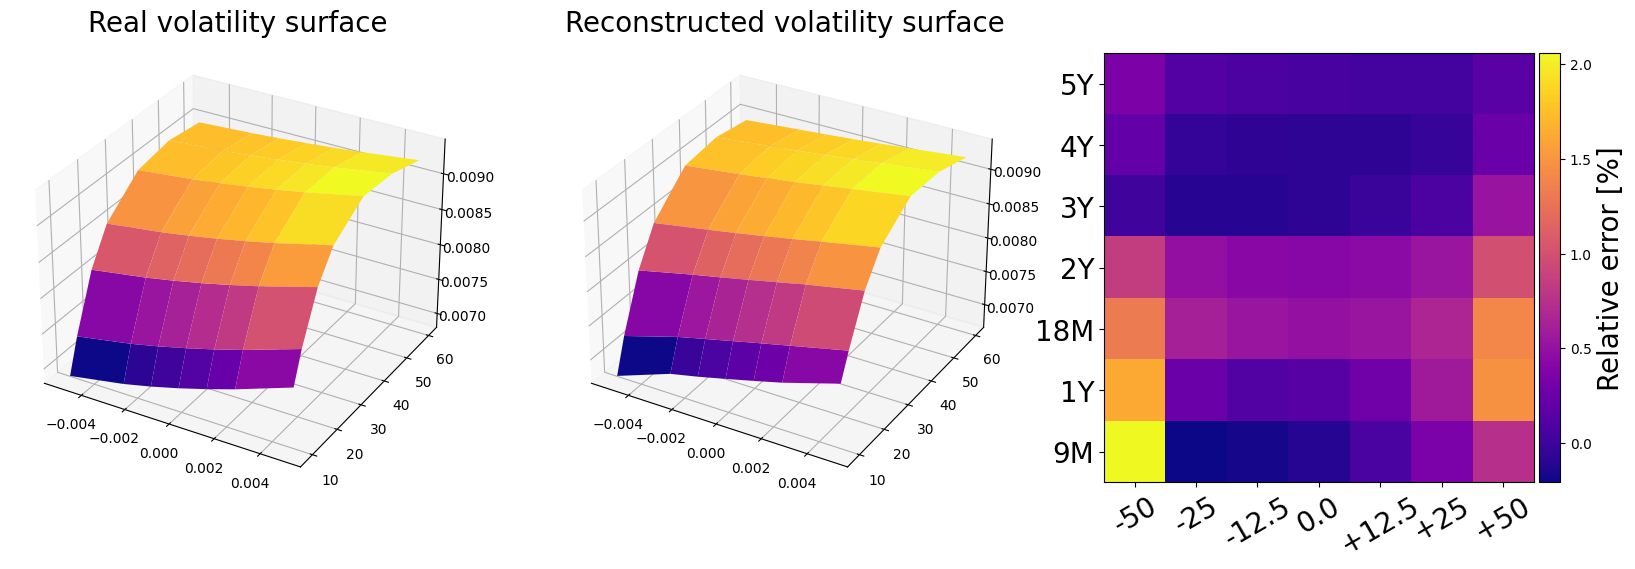

In [56]:
impVol_wmc = []
impVol_real = []

for i in range(49):
    #print(i)
    impVol_wmc.append( impVol_( F=F0, K=Ks[i], t=0, T=Ts[i], C=option_prices_rec_flat[i], pricing_func=objFunc2 ) )
    impVol_real.append( impVol_( F=F0, K=Ks[i], t=0, T=Ts[i], C=option_prices_flat[i], pricing_func=objFunc2 ) )

impVol_wmc_arr = np.array( impVol_wmc )
impVol_real_arr = np.array( impVol_real )

volsurface = impVol_real_arr.reshape( (7,7) )
volsurface_rec = impVol_wmc_arr.reshape( (7,7) )

fs=20

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,3,1, projection="3d")
ax.set_title("Real volatility surface", fontsize=fs)
ax.plot_surface(X, Y, volsurface, cmap="plasma")

ax = fig.add_subplot(1,3,2, projection="3d")
ax.set_title("Reconstructed volatility surface", fontsize=fs)
ax.plot_surface(X, Y, volsurface_rec, cmap="plasma")

ax = fig.add_subplot(1,3,3)
res = (volsurface - volsurface_rec)/volsurface*100
im = ax.imshow( res, cmap="plasma", origin="lower" )
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels( ["-50","-25","-12.5","0.0","+12.5","+25","+50"], fontsize=fs, rotation=30 )
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels( ["9M", "1Y", "18M", "2Y", "3Y", "4Y", "5Y"], fontsize=fs )

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel("Relative error [%]", fontsize=fs)
